In [1]:
# looking again at TE frequency relative to causative event

In [20]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import namedtuple
from seaplotlib.helper import despine, save_fig_in_dir

gff = namedtuple('GFF', 'chrom source feature start end score strand frame sample_id vaf')

In [21]:
ALL_INSERTIONS = '0.5.21.filtered_calls_prosgfp_guts.gff'
DELETION_READ_RATIO = 'pros_purity_estimates_deletion.tab'
LABEL = 'ProsGFP guts'
IMAGE_EXTENSION = 'pdf'

In [22]:
def read_readtagger_confirmed_insertions(path):
    entries = []
    with open(path) as in_file:
        for line in in_file:
            fields = line.strip().split('\t')
            attributes = fields[8]
            attributes = dict([a.split('=') for a in attributes.split(';')])
            fields[8] = attributes['ID'].split('_')[0]
            left_count = int(attributes['total_left_count'])
            right_count = int( attributes['total_right_count'])
            ref_count = int(attributes['nref'])
            fields.append((left_count + right_count) / (left_count + right_count + ref_count))
            entries.append(gff(*fields))
    df = pd.DataFrame.from_records(entries)
    df.columns = list(entries[0]._asdict().keys())
    return df


def transform_df_for_plotting(df):
    """Add autosome column, sorts by sample and variant allele frequency."""
    df['autosome'] = df.chrom.str.len() > 1
    autosome_values = df[df['autosome'] == True].vaf * 2
    # Multiply VAF for autosomes by 2 and cut values at 1
    df.loc[autosome_values.index, 'vaf'] = autosome_values
    # df.loc[df['vaf'] > 1, 'vaf'] = 1
    return df


def read_purity_values(path):
    df = pd.read_csv(path, sep='\t', header=None)
    # This is the (normalized) read ratio of control to tumor
    # We can get the purity 
    df['purity'] = (df[0] - 1) / df[0]
    df.index = df[1]
    return df.purity

In [23]:
df = read_readtagger_confirmed_insertions(ALL_INSERTIONS)
raw_df = transform_df_for_plotting(df)
df = raw_df.copy()
df.loc[df['vaf'] > 1, 'vaf'] = 1
deletion = read_purity_values(DELETION_READ_RATIO)
for i, s_id in enumerate(df['sample_id'].unique()):
    if s_id in deletion.index:
        df.loc[df['sample_id'] == s_id, 'notch_vaf'] = deletion[s_id]
    else:
        # Give some very low AF for plotting
        df.loc[df['sample_id'] == s_id, 'notch_vaf'] = 0 + (1/ (i+1) *100)
# df = df[~df['notch_vaf'].isnull()]
# uncomment this to color by TE
# df['color'] = df['feature']
# df.loc[~df.feature.str.match('rover|I-element|copia'), 'color'] = 'other'
df['color'] = 'other'

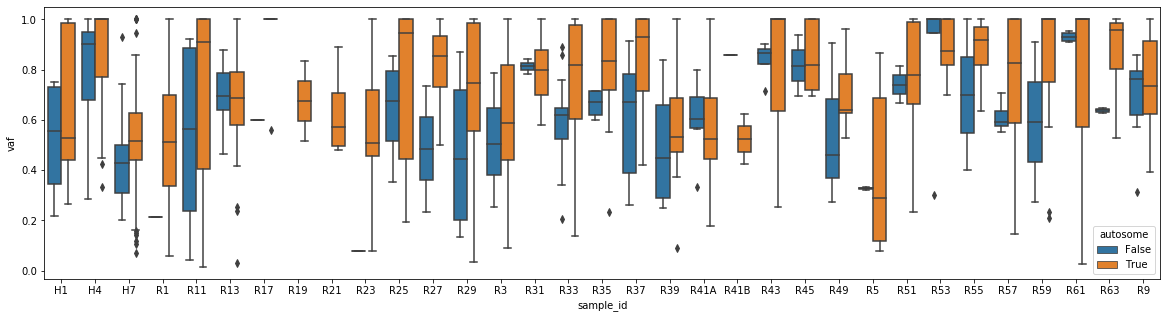

In [24]:
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x="sample_id", y="vaf", hue='autosome', data=df)
# sns.swarmplot(x='sample_id', y='vaf', hue='autosome', data=df, size=10)

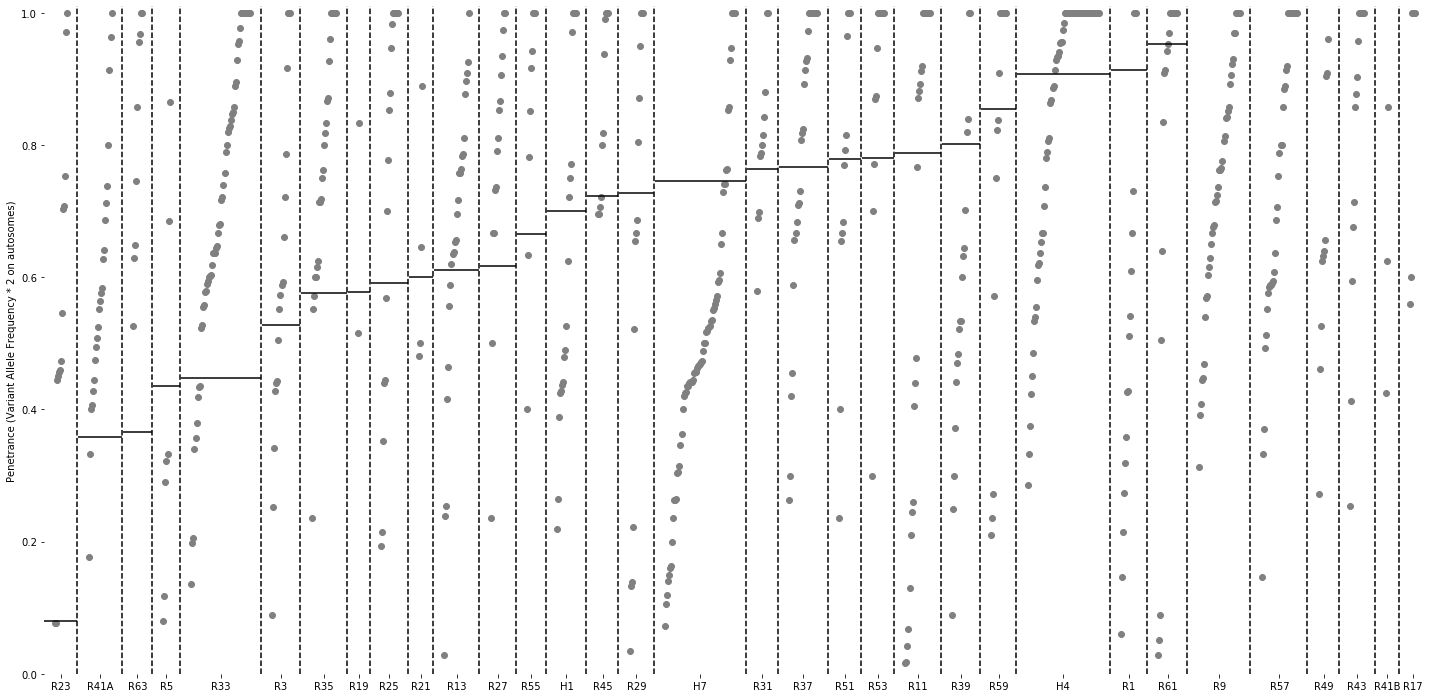

In [25]:
# # Get only X chromosome
# df = df[df['chrom'] == 'X']

def plot_vaf(*args, **kwargs):
    data = kwargs['data']
    xmin = data.order.min() - 10
    xmax = data.order.max() + 10
    y = data.notch_vaf.max()
    ax = plt.gca()
    ax.hlines(y=y, xmin=xmin, xmax=xmax, color=kwargs['color'], label=kwargs['label'])
    
    
def scatter(x, y, **kwargs):
    kwargs.pop('color')
    plt.scatter(x, y, color='grey', **kwargs)

df = df.sort_values(['notch_vaf', 'vaf'])
sample_order = {sample_id: i for i, sample_id in enumerate(df.sample_id.unique())}
df['order'] = list(range(len(df)))
last_addition = 0
for index, group in df.groupby('sample_id').order:
    df.loc[group.index, 'order'] = group.values + (sample_order[index] * 20)

# g = sns.FacetGrid(df, hue="sample_id", col="sample_id",size=8, col_wrap=6, sharex=False)
g = sns.FacetGrid(df, hue="color", aspect=2, height=10)
g.map(scatter, "order", "vaf")
# g.map(plt.plot, "order", "vaf")
# fg = g.map(plt.plot, "order", "notch_vaf")
# plt.axvline(-10, color='k', linestyle='--')
for sep in df.groupby('sample_id')['order'].max().values:
    if not sep == df.order.max():
        plt.axvline(sep + 10, color='k', linestyle='--')


plot_vaf(data=df.groupby('sample_id'), color='black', label=None)
# g.map_dataframe(plot_vaf, 'order', 'notch_vaf')
midpoint_order = df.groupby('sample_id').order.mean()
g.set(xticks=midpoint_order.values)
g.set_xticklabels(midpoint_order.keys())

g.set(xlim=(-10, df.order.max() + 10), ylim=(0, 1.01))

g.set_axis_labels(y_var='Penetrance (Variant Allele Frequency * 2 on autosomes)')
g.set_xlabels(label='')
# fg.set_xticklabels(labels='')
sns.despine(left=True, bottom=True)
# g.add_legend()
save_fig_in_dir(g, 'Insertion Penetrance Estimate %s.%s' % (LABEL, IMAGE_EXTENSION), directory=LABEL, bbox_inches='tight')


In [26]:
quantiles = raw_df.groupby('sample_id')['vaf'].quantile()

In [27]:
upper_half = raw_df[raw_df.apply(lambda row: quantiles[row['sample_id']] > row['vaf'], axis=1)]
lower_half = raw_df[raw_df.apply(lambda row: quantiles[row['sample_id']] < row['vaf'], axis=1)]
frequency_higher_than_notch = df[df.apply(lambda row: row['vaf'] > row['notch_vaf'], axis=1)]
frequency_lower_than_notch = df[df.apply(lambda row: row['vaf'] < row['notch_vaf'], axis=1)]

In [28]:
len(upper_half)

326

In [29]:
len(lower_half)

326

In [30]:
len(frequency_higher_than_notch)

330

In [31]:
len(frequency_lower_than_notch)

344

In [32]:
def to_tsv(df, path):
    df.to_csv(os.path.join(LABEL, path), sep='\t', index=None)

df_path = [
    (upper_half, 'upper_half_insertions.tsv'),
    (lower_half, 'lower_half_insertions.tsv'),
    (frequency_higher_than_notch, 'frequency_higher_than_notch.tsv'),
    (frequency_lower_than_notch, 'frequency_lower_than_notch.tsv'),
]

for df, path in df_path:
    to_tsv(df, path)
